In [2]:
import pandas as pd
import numpy as np
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, ParameterGrid,  GridSearchCV, cross_val_score, cross_val_predict
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, recall_score, precision_score, f1_score, precision_recall_fscore_support, precision_recall_curve
from sklearn.datasets import make_classification
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from mlflow.data.pandas_dataset import PandasDataset
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from fastai.tabular.all import *

#from fastai.callback.data import OverSamplingCallback
from sklearn.tree import DecisionTreeClassifier





mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")




# XGBOOST

0.9850416681168057 0.9713590053923825
[[332992   5535]
 [  4546   8905]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    338527
           1       0.62      0.66      0.64     13451

    accuracy                           0.97    351978
   macro avg       0.80      0.82      0.81    351978
weighted avg       0.97      0.97      0.97    351978

0.8228411579151049


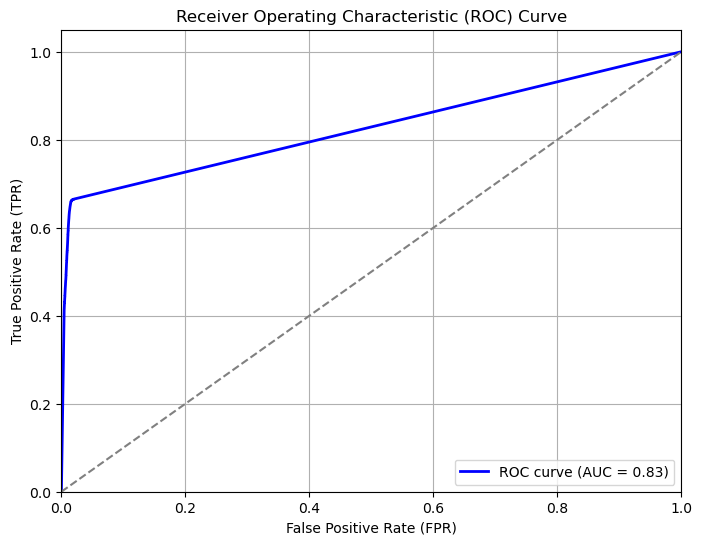

c:\Users\SL\anaconda3\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
c:\Users\SL\anaconda3\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]
c:\Users\SL\anaconda3\Lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) tha

In [22]:

# Load the data
df = pd.read_parquet('../data/data_clean5.parquet')

# Define the features and target
X = df.drop('Returned', axis=1)
y = df['Returned']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Define the categorical features
categorical_feature = ['Shop','CustomerID','ProductCode',  'BrandName',  'ModelGroup', 'ProductGroup', 'SaleDocumentNumber', 'Order_Date_FK']

# Initialize the target encoder
encoder = TargetEncoder(cols=categorical_feature, handle_unknown='mean', handle_missing='mean')

# Fit and transform the encoder on the training set
X_train_encoded = encoder.fit_transform(X_train, y_train)

# Transform the test set
X_test_encoded = encoder.transform(X_test)
target_mean = y_train.mean()
X_test_encoded = X_test_encoded.fillna(target_mean)  # ensuring that no nan value are present

# Instantiate SMOTE and resample the training data
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)

# Normalize the data
sc = StandardScaler()
X_train_normalized = sc.fit_transform(X_train_resampled)  # fit on train and transform train 
X_test_normalized = sc.transform(X_test_encoded) # transform test with the same scaler based on train 
# ros = RandomOverSampler(random_state=10)
# X_train_encoded, y_train = ros.fit_resample(X_train_encoded, y_train)

print (X_train_normalized.hea)

# # train and use the model  the model 
# param_grid= {
#     'learning_rate': [0.01, 0.1, 0.3],
#     'n_estimators': [200,500,750, 1000],
#     'max_depth': [3,8,12],
#     'subsample': [0.4, 0.6],
#     'gamma': [0, 0,2],
#     'scale_pos_weight':[8,12, 18]
#}
xgb = XGBClassifier()

# #Create a log file
# with open('grid_search_log2.txt', 'w') as f:
#     for g in ParameterGrid(param_grid):
#         xgb.set_params(**g)
#         xgb.fit(X_train_encoded, y_train)
#         y_pred = xgb.predict(X_test_encoded)
#         report = classification_report(y_test, y_pred, output_dict=True)
#         report2 = roc_auc_score(y_test, y_pred)
#         tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

#         f.write(f"""Params: {g}, Precision: {report['macro avg']['precision']}, Recall: {report['macro avg']['recall']},
#                 F1 Score: {report['macro avg']['f1-score']}, Accuracy: {report['accuracy']},
#                 True Negatives: {tn}, True Positives: {tp}, False Positives: {fp}, False Negatives: {fn}, 
#                 ROC : {report2}, \n""")
#         f.flush()
#         os.fsync(f.fileno())


# grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='f1')
# grid_search.fit(X_train_encoded, y_train)
# grid_search.best_params_
# print(grid_search.best_params_)
# print(grid_search.best_score_)




param = {'gamma': 2, 'learning_rate': 0.01, 'max_depth': 12, 'n_estimators': 500, 'subsample': 0.6, 'scale_pos_weight': 18}
xgb = XGBClassifier(**param)
xgb.fit(X_train_encoded, y_train)
y_pred = xgb.predict(X_test_encoded)

# Evaluate results
accuracy_train = xgb.score(X_train_encoded, y_train)
accuracy_test = xgb.score(X_test_encoded, y_test)
conf = confusion_matrix(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
support = precision_recall_fscore_support(y_test, y_pred)
curve = precision_recall_curve(y_test, y_pred)
classification = classification_report(y_test, y_pred)
print(accuracy_train, accuracy_test) 
print(conf)
print(classification_report(y_test, y_pred))
print(roc)

y_pred_proba = xgb.predict_proba(X_test_encoded)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#--------------------------------------------------------------------------------------------------------------

#at the end of the code, launch the experiment : 
mlflow.set_experiment("Returns_predictions_XGB")

# mention the dataset used
dataset: PandasDataset = mlflow.data.from_pandas(df, source='../data/data_clean.parquet')


# Start an MLflow run
with mlflow.start_run():

     # Log the input data
     #mlflow.log_input(dataset, context="TRN")
     #mlflow.log_artifact("df.csv")

    # Log the hyperparameters from the model (they should in the variable in the code)
    mlflow.log_params(param)
    
     
     #log the rando and TT split
    mlflow.log_param("testsplit_size", 0.2)
    mlflow.log_param("random_state", 10)
     
     # Log the loss metric
    mlflow.log_metric("accuracy_test", accuracy_test)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("roc_score", roc)
     #mlflow.log_metric("curve", curve)
     #mlflow.log_metric("conf_matrix", conf)
     #mlflow.log_metric("support", support)
     #mlflow.log_metric("classification", classification)
        

     # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Comments", "with smote rebalancing")
       
#    # if prediction are not runed in the model (cause cluster for ex) run them here
#     predictions = ward.fit_predict(dfs)

     # Infer the model signature
    signature = infer_signature(X_test, y_pred)

     # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=XGBClassifier, #model to log
        artifact_path="XGB",  #local path for saving that model 
        signature=signature, #log the scheme of input&output - names, datatype, shape tec..
        input_example=df, #useful for model later use to check/exemplify the right data format
        registered_model_name="XGB" #name of the model in the mlflow UI
        )


# RANDOMFOREST

1407911 351978 1407911 351978
0.9991100289720017 0.9793396178170226
[[336411   2116]
 [  5156   8295]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    338527
           1       0.80      0.62      0.70     13451

    accuracy                           0.98    351978
   macro avg       0.89      0.81      0.84    351978
weighted avg       0.98      0.98      0.98    351978

0.8052160826288708


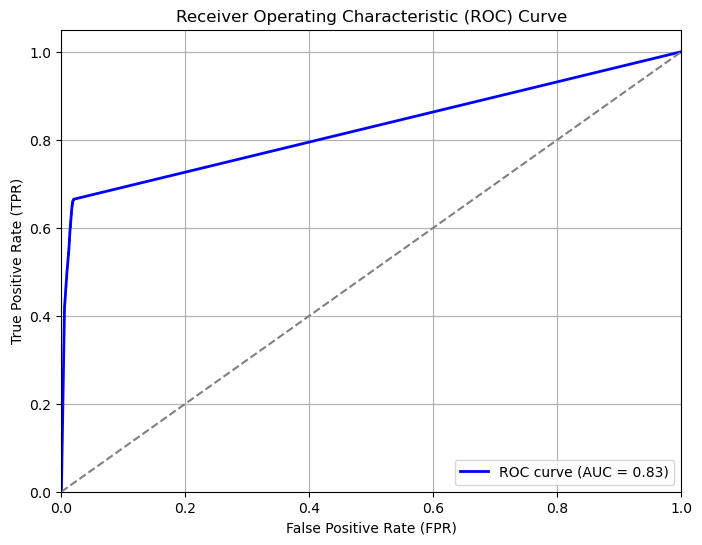

c:\Users\SL\anaconda3\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
c:\Users\SL\anaconda3\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]
c:\Users\SL\anaconda3\Lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) tha

In [215]:
# prepare the data

df=pd.read_parquet('../data/data_clean5.parquet')
  


X=df.drop('Returned',axis=1)
y=df['Returned']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
print (len(X_train), len(X_test), len(y_train), len(y_test))

#Encode categorical features using TargetEncoder
categorical_feature = ['Shop','CustomerID','ProductCode',  'BrandName',  'ModelGroup', 'ProductGroup', 'SaleDocumentNumber', 'Order_Date_FK'] # Select the categorical feature to encode
encoder = ce.TargetEncoder(cols=categorical_feature, handle_unknown='mean', handle_missing = 'mean') # Initialize the target encoder
X_train_encoded1 = encoder.fit_transform(X_train, y_train) # Fit and transform the encoder on the DataFrame
X_test_encoded1 = encoder.transform(X_test)  # Fit and transform the encoder on the DataFrame
target_mean = y_train.mean()
X_test_encoded1 = X_test_encoded1.fillna(target_mean)  # ensuring that no nan value are present



# Normalize the data
sc = StandardScaler()
X_train_encoded = sc.fit_transform(X_train_encoded1)  # fit on train and transform train 
X_test_encoded = sc.transform(X_test_encoded1) # transform test with the same scaler based on train 

# # train and use the model  the model 
# params_grid = {
#     'n_estimators': [50, 100, 200],
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [None, 10, 25],
#     'min_samples_split': [2, 7],
#     'min_samples_leaf': [1, 4],
#     'max_features': ['sqrt'],
#     'bootstrap': [True],
#     'class_weight': [None]
#  }

rdf = RandomForestClassifier()
# #Create a log file
# with open('grid_search_log_RDF1.txt', 'w') as f:
#     for g in ParameterGrid(params_grid):
#         rdf.set_params(**g)
#         rdf.fit(X_train_encoded, y_train)
#         y_pred = rdf.predict(X_test_encoded)
#         report = classification_report(y_test, y_pred, output_dict=True)
#         tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

#         f.write(f"""Params: {g}, Precision: {report['macro avg']['precision']}, Recall: {report['macro avg']['recall']},
#                 F1 Score: {report['macro avg']['f1-score']}, Accuracy: {report['accuracy']},
#                 True Negatives: {tn}, True Positives: {tp}, False Positives: {fp}, False Negatives: {fn}, 
#                 ROC : {report2}, \n""")
#         f.flush()
#         os.fsync(f.fileno())


# grid_search = GridSearchCV(rdf, param_grid, cv=5, scoring='f1')
# grid_search.fit(X_train_encoded, y_train)
# grid_search.best_params_
# print(grid_search.best_params_)




params = {
    'n_estimators': 100,
    'criterion': 'gini',
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': None,
    'bootstrap': True,
    'class_weight': None,
    'random_state': 42
}
rdf = RandomForestClassifier (**params)
rdf.fit(X_train_encoded, y_train)
y_pred = rdf.predict(X_test_encoded)

# Evaluate results
accuracy_train = rdf.score(X_train_encoded, y_train)
accuracy_test = rdf.score(X_test_encoded, y_test)
conf = confusion_matrix(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
support = precision_recall_fscore_support(y_test, y_pred)
curve = precision_recall_curve(y_test, y_pred)
classification = classification_report(y_test, y_pred)
print(accuracy_train, accuracy_test) 
print(conf)
print(classification_report(y_test, y_pred))
print(roc)

y_pred_proba = xgb.predict_proba(X_test_encoded)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
#--------------------------------------------------------------------------------------------------------------

#at the end of the code, launch the experiment : 
mlflow.set_experiment("Returns_predictions_RDF")

# mention the dataset used
dataset: PandasDataset = mlflow.data.from_pandas(df, source='../data/data_clean.parquet')


# Start an MLflow run
with mlflow.start_run():

     # Log the input data
     #mlflow.log_input(dataset, context="TRN")
     #mlflow.log_artifact("df.csv")



    # Log the hyperparameters from the model (they should in the variable in the code)
     mlflow.log_params(params)

 #log the  TT split
     mlflow.log_param("testsplit_size", 0.2)
     
     
    
     # Log the loss metric
     mlflow.log_metric("accuracy_test", accuracy_test)
     mlflow.log_metric("precision", precision)
     mlflow.log_metric("recall", recall)
     mlflow.log_metric("f1_score", f1)
     mlflow.log_metric("roc_score", roc)
     #mlflow.log_metric("curve", curve)
     #mlflow.log_metric("conf_matrix", conf)
     #mlflow.log_metric("support", support)
     #mlflow.log_metric("classification", classification)
        

     # Set a tag that we can use to remind ourselves what this run was for
     mlflow.set_tag("Comments", "same run as XGB upbeat-ray-650")
       
#    # if prediction are not runed in the model (cause cluster for ex) run them here
#     predictions = ward.fit_predict(dfs)

     # Infer the model signature
     signature = infer_signature(X_test, y_pred)

     # Log the model
     model_info = mlflow.sklearn.log_model(
        sk_model=RandomForestClassifier, #model to log
        artifact_path="RDF",  #local path for saving that model 
        signature=signature, #log the scheme of input&output - names, datatype, shape tec..
        input_example=df, #useful for model later use to check/exemplify the right data format
        registered_model_name="RDF" #name of the model in the mlflow UI
     )


In [3]:
import csv

# Open the text file and the output CSV file
with open('grid_search_log2.txt', 'r') as in_file, open('output_xgb2.csv', 'w', newline='') as out_file:
    # Create a CSV writer
    writer = csv.writer(out_file)
    # For each line in the input file
    for line in in_file:
        # Write the line to the CSV file, splitting on whitespace
        writer.writerow(line.rstrip().split(','))

1407911 351978 1407911 351978
1015173 1015173 351978 351978
0.9993518346134107 0.976634903317821
[[335011   3516]
 [  4708   8743]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    338527
           1       0.71      0.65      0.68     13451

    accuracy                           0.98    351978
   macro avg       0.85      0.82      0.83    351978
weighted avg       0.98      0.98      0.98    351978

0.8198013376874304


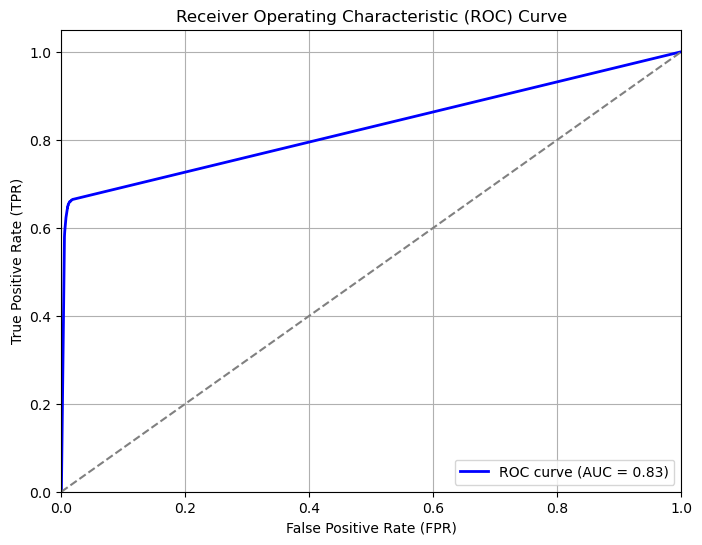

c:\Users\SL\anaconda3\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
c:\Users\SL\anaconda3\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]
c:\Users\SL\anaconda3\Lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) tha

In [16]:
#UNDER OVER SAMPLING

df=pd.read_parquet('../data/data_clean5.parquet')
  

X=df.drop('Returned',axis=1)
y=df['Returned']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
print (len(X_train), len(X_test), len(y_train), len(y_test))


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Define the categorical features
categorical_feature = ['Shop','CustomerID','ProductCode',  'BrandName',  'ModelGroup', 'ProductGroup', 'SaleDocumentNumber', 'Order_Date_FK']

# Initialize the target encoder
encoder = ce.TargetEncoder(cols=categorical_feature, handle_unknown='mean', handle_missing='mean')

# Fit and transform the encoder on the training set
X_train_encoded = encoder.fit_transform(X_train, y_train)

# Transform the test set
X_test_encoded = encoder.transform(X_test)
target_mean = y_train.mean()
X_test_encoded = X_test_encoded.fillna(target_mean)  # ensuring that no nan value are present

# Instantiate SMOTE and resample the training data  
#smote = SMOTE(sampling_strategy='auto', random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)

# Instantiate RandomUnderSampler
ros = RandomOverSampler(sampling_strategy=0.25, random_state=10)
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

# Fit and resample the training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_encoded, y_train)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_resampled, y_train_resampled)

# Normalize the data
sc = StandardScaler()
X_train_normalized = sc.fit_transform(X_train_resampled)  # fit on train and transform train 
X_test_normalized = sc.transform(X_test_encoded) # transform test with the same scaler based on train 
print (len(X_train_normalized), len(y_train_resampled), len(X_test_normalized), len(y_test))


# # train and use the model  the model 
# params_grid = {
#     'n_estimators': [50, 100, 200],
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [None, 10, 25],
#     'min_samples_split': [2, 7],
#     'min_samples_leaf': [1, 4],
#     'max_features': ['sqrt'],
#     'bootstrap': [True],
#     'class_weight': [None]
#  }

rdf = RandomForestClassifier()
# #Create a log file
# with open('grid_search_log_RDF1.txt', 'w') as f:
#     for g in ParameterGrid(params_grid):
#         rdf.set_params(**g)
#         rdf.fit(X_train_encoded, y_train)
#         y_pred = rdf.predict(X_test_encoded)
#         report = classification_report(y_test, y_pred, output_dict=True)
#         tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

#         f.write(f"""Params: {g}, Precision: {report['macro avg']['precision']}, Recall: {report['macro avg']['recall']},
#                 F1 Score: {report['macro avg']['f1-score']}, Accuracy: {report['accuracy']},
#                 True Negatives: {tn}, True Positives: {tp}, False Positives: {fp}, False Negatives: {fn}, 
#                 ROC : {report2}, \n""")
#         f.flush()
#         os.fsync(f.fileno())


# grid_search = GridSearchCV(rdf, param_grid, cv=5, scoring='f1')
# grid_search.fit(X_train_encoded, y_train)
# grid_search.best_params_
# print(grid_search.best_params_)




params = {
    'n_estimators': 100,
    'criterion': 'entropy',
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': None,
    'bootstrap': True,
    'class_weight': 'balanced',
    'random_state': 42
}
rdf = RandomForestClassifier (**params)
rdf.fit(X_train_normalized, y_train_resampled)
y_pred = rdf.predict(X_test_normalized)

# Evaluate results
accuracy_train = rdf.score(X_train_normalized, y_train_resampled)
accuracy_test = rdf.score(X_test_normalized, y_test)
conf = confusion_matrix(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
support = precision_recall_fscore_support(y_test, y_pred)
curve = precision_recall_curve(y_test, y_pred)
classification = classification_report(y_test, y_pred)
print(accuracy_train, accuracy_test) 
print(conf)
print(classification_report(y_test, y_pred))
print(roc)

y_pred_proba = rdf.predict_proba(X_test_normalized)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
#--------------------------------------------------------------------------------------------------------------

#at the end of the code, launch the experiment : 
mlflow.set_experiment("Returns_predictions_RDF")

# mention the dataset used
dataset: PandasDataset = mlflow.data.from_pandas(df, source='../data/data_clean.parquet')


# Start an MLflow run
with mlflow.start_run():

     # Log the input data
     #mlflow.log_input(dataset, context="TRN")
     #mlflow.log_artifact("df.csv")



    # Log the hyperparameters from the model (they should in the variable in the code)
     mlflow.log_params(params)

 #log the  TT split
     mlflow.log_param("testsplit_size", 0.2)
     
     
    
     # Log the loss metric
     mlflow.log_metric("accuracy_test", accuracy_test)
     mlflow.log_metric("precision", precision)
     mlflow.log_metric("recall", recall)
     mlflow.log_metric("f1_score", f1)
     mlflow.log_metric("roc_score", roc)
     #mlflow.log_metric("curve", curve)
     #mlflow.log_metric("conf_matrix", conf)
     #mlflow.log_metric("support", support)
     #mlflow.log_metric("classification", classification)
        

     # Set a tag that we can use to remind ourselves what this run was for
     mlflow.set_tag("Comments", "with over and under to get 50% ratio")
       
#    # if prediction are not runed in the model (cause cluster for ex) run them here
#     predictions = ward.fit_predict(dfs)

     # Infer the model signature
     signature = infer_signature(X_test, y_pred)

     # Log the model
     model_info = mlflow.sklearn.log_model(
        sk_model=RandomForestClassifier, #model to log
        artifact_path="RDF",  #local path for saving that model 
        signature=signature, #log the scheme of input&output - names, datatype, shape tec..
        input_example=df, #useful for model later use to check/exemplify the right data format
        registered_model_name="RDF" #name of the model in the mlflow UI   
    )


# ANN : Keyra


In [ ]:
#ANN

df=pd.read_parquet('../data/data_clean5.parquet')
  

X=df.drop('Returned',axis=1)
y=df['Returned']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
print (len(X_train), len(X_test), len(y_train), len(y_test))


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Define the categorical features
categorical_feature = ['Shop','CustomerID','ProductCode',  'BrandName',  'ModelGroup', 'ProductGroup', 'SaleDocumentNumber', 'Order_Date_FK']

# Initialize the target encoder
encoder = ce.TargetEncoder(cols=categorical_feature, handle_unknown='mean', handle_missing='mean')

# Fit and transform the encoder on the training set
X_train_encoded = encoder.fit_transform(X_train, y_train)

# Transform the test set
X_test_encoded = encoder.transform(X_test)
target_mean = y_train.mean()
X_test_encoded = X_test_encoded.fillna(target_mean)  # ensuring that no nan value are present

# Instantiate SMOTE and resample the training data  
#smote = SMOTE(sampling_strategy='auto', random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)

# Instantiate RandomUnderSampler
# ros = RandomOverSampler(sampling_strategy=0.25, random_state=10)
# rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

# Fit and resample the training data
# X_train_resampled, y_train_resampled = ros.fit_resample(X_train_encoded, y_train)
# X_train_resampled, y_train_resampled = rus.fit_resample(X_train_resampled, y_train_resampled)

# Normalize the data
sc = StandardScaler()
X_train_normalized = sc.fit_transform(X_train_encoded)  # fit on train and transform train 
X_test_normalized = sc.transform(X_test_encoded) # transform test with the same scaler based on train 
print (len(X_train_normalized), len(y_train), len(X_test_normalized), len(y_test))

# # Calculate class weights
# unique_classes = np.unique(y_train)
# class_weights = compute_sample_weight(class_weight='balanced', y=y_train)
# class_weight_dict = {cls: weight for cls, weight in zip(unique_classes, class_weights)}

# Calculate class weights
unique_classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train)
class_weight_dict = dict(zip(unique_classes, class_weights))

print("Unique values in y_train: ", np.unique(y_train))
print("Keys in class_weight_dict: ", class_weight_dict.keys())

# Define the model
model = Sequential()
model.add(Dense(32, input_dim=X_train_normalized.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Convert y_train to a numpy array
y_train_array = np.array(y_train)


# Fit the model with class weights
model.fit(X_train_normalized, y_train_array, epochs=10, batch_size=32, validation_data=(X_test_normalized, y_test), class_weight=class_weight_dict)







# Evaluate the model
_, accuracy_train = model.evaluate(X_train_normalized, y_train_array)
_, accuracy_test = model.evaluate(X_test_normalized, y_test)
print('Train Accuracy: %.2f' % (accuracy_train*100))
print('Test Accuracy: %.2f' % (accuracy_test*100))


# # train and use the model  the model 
# params_grid = {
#     'n_estimators': [50, 100, 200],
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [None, 10, 25],
#     'min_samples_split': [2, 7],
#     'min_samples_leaf': [1, 4],
#     'max_features': ['sqrt'],
#     'bootstrap': [True],
#     'class_weight': [None]
#  }

#rdf = RandomForestClassifier()
# #Create a log file
# with open('grid_search_log_RDF1.txt', 'w') as f:
#     for g in ParameterGrid(params_grid):
#         rdf.set_params(**g)
#         rdf.fit(X_train_encoded, y_train)
#         y_pred = rdf.predict(X_test_encoded)
#         report = classification_report(y_test, y_pred, output_dict=True)
#         tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

#         f.write(f"""Params: {g}, Precision: {report['macro avg']['precision']}, Recall: {report['macro avg']['recall']},
#                 F1 Score: {report['macro avg']['f1-score']}, Accuracy: {report['accuracy']},
#                 True Negatives: {tn}, True Positives: {tp}, False Positives: {fp}, False Negatives: {fn}, 
#                 ROC : {report2}, \n""")
#         f.flush()
#         os.fsync(f.fileno())


# grid_search = GridSearchCV(rdf, param_grid, cv=5, scoring='f1')
# grid_search.fit(X_train_encoded, y_train)
# grid_search.best_params_
# print(grid_search.best_params_)


# params = {
#     'n_estimators': 100,
#     'criterion': 'entropy',
#     'max_depth': None,
#     'min_samples_split': 2,
#     'min_samples_leaf': 1,
#     'max_features': None,
#     'bootstrap': True,
#     #'class_weight': 'balanced',
#     'random_state': 42
# }
# rdf = RandomForestClassifier (**params)
# rdf.fit(X_train_normalized, y_train_resampled)
# y_pred = rdf.predict(X_test_normalized)


# Predict probabilities for test set
y_pred_probs = model.predict(X_test_normalized)

# Predict classes for test set
y_pred = (y_pred_probs > 0.5).astype('int32')

# Evaluate predictions
conf = confusion_matrix(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
support = precision_recall_fscore_support(y_test, y_pred)
curve = precision_recall_curve(y_test, y_pred)
classification = classification_report(y_test, y_pred)

print(conf)
print(classification)
print(roc)

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


#--------------------------------------------------------------------------------------------------------------

#at the end of the code, launch the experiment : 
mlflow.set_experiment("Returns_predictions_ANN_Keras")

# mention the dataset used
dataset: PandasDataset = mlflow.data.from_pandas(df, source='../data/data_clean.parquet')



# Set the experiment
mlflow.set_experiment("Returns_predictions_ANN_Keras")

# Start an MLflow run
with mlflow.start_run():

    # Log the test split size and the random state
    mlflow.log_param("testsplit_size", 0.2)

    # Log the hyperparameters from the model
    params = {'epochs': 10, 'batch_size': 32, 'layers': [32, 16, 1], 'activation': 'relu', 'output_activation': 'sigmoid'}
    mlflow.log_params(params)

    # Log the compilation parameters 
    mlflow.log_param("loss_function", 'binary_crossentropy')
    mlflow.log_param("optimizer", 'Adam')
    mlflow.log_param("metrics", 'accuracy') 


    # Log the metrics
    mlflow.log_metric("accuracy_test", accuracy_test)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("roc_score", roc)


    # Set a tag
    mlflow.set_tag("Comments", "First ANN ever")

    # Infer the model signature
    signature = infer_signature(X_test_normalized, model.predict(X_test_normalized))

    # Log the model
    mlflow.keras.log_model(
        model=model,  # model to log
        artifact_path="Keras",  # local path for saving that model
        signature=signature,  # log the scheme of input&output - names, datatype, shape etc..
        input_example=X_test_normalized[0],  # useful for model later use to check/exemplify the right data format
        registered_model_name="Keras"  # name of the model in the mlflow UI
    )

# ANN 2 : fastai.tabular

In [25]:
#ANN

df=pd.read_parquet('../data/data_clean5.parquet')
  

# X=df.drop('Returned',axis=1)
# y=df['Returned']  

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
# print (len(X_train), len(X_test), len(y_train), len(y_test))


# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# # Define the categorical features
# categorical_feature = ['Shop','CustomerID','ProductCode',  'BrandName',  'ModelGroup', 'ProductGroup', 'SaleDocumentNumber', 'Order_Date_FK']

# # Initialize the target encoder
# encoder = ce.TargetEncoder(cols=categorical_feature, handle_unknown='mean', handle_missing='mean')

# # Fit and transform the encoder on the training set
# X_train_encoded = encoder.fit_transform(X_train, y_train)

# # Transform the test set
# X_test_encoded = encoder.transform(X_test)
# target_mean = y_train.mean()
# X_test_encoded = X_test_encoded.fillna(target_mean)  # ensuring that no nan value are present
# # Normalize the data
# sc = StandardScaler()
# X_train_normalized = sc.fit_transform(X_train_encoded)  # fit on train and transform train 
# X_test_normalized = sc.transform(X_test_encoded) # transform test with the same scaler based on train 
# print (len(X_train_normalized), len(y_train), len(X_test_normalized), len(y_test))


# Define categorical and continuous variables
cat_names = ['Shop','CustomerID','ProductCode',  'BrandName',  'ModelGroup', 'ProductGroup', 'SaleDocumentNumber', 'Order_Date_FK']
cont_names = list(set(df.columns) - set(cat_names + ['Returned']))

# Define the target variable
dep_var = 'Returned'

# Define the pre-processing steps
procs = [Categorify, FillMissing, Normalize]

# Split the data into training and validation sets
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

# Define the TabularPandas object
to = TabularPandas(df, procs, cat_names, cont_names, y_names=dep_var, splits=splits)


# Convert the TabularPandas object to a DataLoaders object
dls = to.dataloaders(bs=5000)
dls.show_batch()


# Define the model
learn = tabular_learner(dls, layers=[20,10], metrics=accuracy)

# Train the model
learn.fit_one_cycle(2)

# Get predictions
preds, targs = learn.get_preds()

# Convert predictions to binary
preds_bin = (preds > 0.5).int()


tab_learn = tabular_learner(df, metrics=[accuracy, error_rate, Recall(), Precision()])

# Evaluate predictions
conf = confusion_matrix(targs, preds_bin)
roc = roc_auc_score(targs, preds_bin)
precision = precision_score(targs, preds_bin)
recall = recall_score(targs, preds_bin)
f1 = f1_score(targs, preds_bin)
support = precision_recall_fscore_support(targs, preds_bin)
curve = precision_recall_curve(targs, preds_bin)
classification = classification_report(targs, preds_bin)

print(conf)
print(classification)
print(roc)

# Plot the ROC curve
fpr, tpr, _ = roc_curve(targs, preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

,Shop,CustomerID,ProductCode,BrandName,ModelGroup,ProductGroup,SaleDocumentNumber,Order_Date_FK,day_of_week_Tuesday,day_of_week_Thursday,nb_similar_item_tx,day_of_week_Wednesday,day_of_week_Monday,OriginalSaleAmountInclVAT,profit_%,discount_rate_%,nb_item_tx,day_of_week_Saturday,RevenueInclVAT,CostPriceExclVAT,day_of_week_Sunday,Returned
0,77,-4399869717222274822,1397359831794813577,-4445228402666777776,3162564956579801398,-453682476182549203,23488187,2021-06-05,-1.396573e-09,2.830714e-09,2.0,-1.894070e-09,-2.157571e-09,65.949997,65.403405,2.274450e+00,8.0,1.000000e+00,64.449997,21.316456,-4.610345e-09,0.0
1,13,-1744158556444181355,-4003396437688420904,-1657270726128381662,-4124706989267335995,-453682476182549203,23858890,2021-07-14,-1.396573e-09,2.830714e-09,2.0,1.000000e+00,-2.157571e-09,59.950001,72.477067,-1.287916e-07,2.0,1.318678e-09,59.950001,16.500000,-4.610345e-09,0.0
2,52,-7223621638735958792,-5150864728018191211,-5337325358582794831,8676381074854750838,2500932515802331300,23925518,2021-07-22,-1.396573e-09,1.000000e+00,2.0,-1.894070e-09,-2.157571e-09,29.990000,74.104699,-1.287916e-07,2.0,1.318678e-09,29.989999,7.766000,-4.610345e-09,0.0
3,7,-5274373356868953113,-4003396437688420904,-1657270726128381662,-4124706989267335995,-453682476182549203,23981218,2021-07-28,-1.396573e-09,2.830714e-09,2.0,1.000000e+00,-2.157571e-09,59.950001,72.477067,-1.287916e-07,2.0,1.318678e-09,59.950001,16.500000,-4.610345e-09,0.0
4,76,-6266716145988366121,3774410288741610618,-3001169043836376081,-4124706989267335995,-453682476182549203,23956210,2021-07-26,-1.396573e-09,2.830714e-09,2.0,-1.894070e-09,1.000000e+00,55.950001,65.662720,-1.287916e-07,2.0,1.318678e-09,55.950001,19.211710,-4.610345e-09,0.0
5,59,4244231978384122877,6716538699072456310,6988179278806901179,-4124706989267335995,-453682476182549203,23889957,2021-07-17,-1.396573e-09,2.830714e-09,2.0,-1.894070e-09,-2.157571e-09,45.950001,56.134926,1.499456e+01,2.0,1.000000e+00,39.060001,13.266001,-4.610345e-09,0.0
6,57,6697563861972790776,5531554600464038250,-1671135878886367730,-4124706989267335995,-453682476182549203,23996108,2021-07-30,-1.396573e-09,2.830714e-09,2.0,-1.894070e-09,-2.157571e-09,35.950001,56.189152,-1.287916e-07,2.0,1.318678e-09,35.950001,15.750000,-4.610345e-09,0.0
7,85,-281936251878434283,6134152380942927445,-3734237314099258167,-4124706989267335995,-453682476182549203,23938500,2021-07-23,-1.396573e-09,2.830714e-09,2.0,-1.894070e-09,-2.157571e-09,109.999999,36.693738,2.500000e+01,2.0,1.318678e-09,82.499999,42.136891,-4.610345e-09,0.0
8,63,-322146092597321512,-7107867639281117173,-1657270726128381662,6742804956075612187,-5386210342051699146,24106719,2021-08-13,-1.396573e-09,2.830714e-09,2.0,-1.894070e-09,-2.157571e-09,7.989999,46.440552,1.501877e+01,6.0,1.318678e-09,6.790000,3.079400,-4.610345e-09,0.0
9,102,8418253009843024686,4419178311891869417,7924821923969469977,-4124706989267335995,-453682476182549203,23958950,2021-07-25,-1.396573e-09,2.830714e-09,1.0,-1.894070e-09,-2.157571e-09,120.000000,21.829429,4.000000e+01,1.0,1.318678e-09,72.000000,45.804688,1.000000e+00,0.0


epoch,train_loss,valid_loss,accuracy,time
0,0.036950,0.028023,0.961344,24:02
1,0.014618,0.024896,0.961344,21:17


AttributeError: 'DataFrame' object has no attribute 'train_ds'

# decision tree

In [20]:
df=pd.read_parquet('../data/data_clean5.parquet')
  

X=df.drop('Returned',axis=1)
y=df['Returned']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
print (len(X_train), len(X_test), len(y_train), len(y_test))


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Define the categorical features
categorical_feature = ['Shop','CustomerID','ProductCode',  'BrandName',  'ModelGroup', 'ProductGroup', 'SaleDocumentNumber', 'Order_Date_FK']

# Initialize the target encoder
encoder = ce.TargetEncoder(cols=categorical_feature, handle_unknown='mean', handle_missing='mean')

# Fit and transform the encoder on the training set
X_train_encoded = encoder.fit_transform(X_train, y_train)

# Transform the test set
X_test_encoded = encoder.transform(X_test)
target_mean = y_train.mean()
X_test_encoded = X_test_encoded.fillna(target_mean)  # ensuring that no nan value are present

# Instantiate SMOTE and resample the training data  
#smote = SMOTE(sampling_strategy='auto', random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)

# Instantiate RandomUnderSampler
ros = RandomOverSampler(sampling_strategy=0.25, random_state=10)
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

# Fit and resample the training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_encoded, y_train)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_resampled, y_train_resampled)

# Normalize the data
sc = StandardScaler()
X_train_normalized = sc.fit_transform(X_train_resampled)  # fit on train and transform train 
X_test_normalized = sc.transform(X_test_encoded) # transform test with the same scaler based on train 
print (len(X_train_normalized), len(y_train_resampled), len(X_test_normalized), len(y_test))


# Define the parameters for the DecisionTreeClassifier
params = {
    'criterion': 'gini',
    'splitter': 'best',
    'max_depth': None,
    'min_samples_split': 3,
    'min_samples_leaf': 2,
    'max_features': None,
    'class_weight': 'balanced',
    'random_state': 42
}

# Instantiate the DecisionTreeClassifier
dtc = DecisionTreeClassifier(**params)

# Fit the model to the training data
dtc.fit(X_train_normalized, y_train_resampled)

# Predict the labels of the test set
y_pred = dtc.predict(X_test_normalized)

# Evaluate the model
accuracy_train = dtc.score(X_train_normalized, y_train_resampled)
accuracy_test = dtc.score(X_test_normalized, y_test)
conf = confusion_matrix(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
support = precision_recall_fscore_support(y_test, y_pred)
curve = precision_recall_curve(y_test, y_pred)
classification = classification_report(y_test, y_pred)

print(accuracy_train, accuracy_test) 
print(conf)
print(classification_report(y_test, y_pred))
print(roc)

#at the end of the code, launch the experiment : 
mlflow.set_experiment("Returns_predictions_DTC")

# mention the dataset used
dataset: PandasDataset = mlflow.data.from_pandas(df, source='../data/data_clean.parquet')


# Start an MLflow run
with mlflow.start_run():

     # Log the input data
     #mlflow.log_input(dataset, context="TRN")
     #mlflow.log_artifact("df.csv")



    # Log the hyperparameters from the model (they should in the variable in the code)
     mlflow.log_params(params)

 #log the  TT split
     mlflow.log_param("testsplit_size", 0.2)
     
     
    
     # Log the loss metric
     mlflow.log_metric("accuracy_test", accuracy_test)
     mlflow.log_metric("precision", precision)
     mlflow.log_metric("recall", recall)
     mlflow.log_metric("f1_score", f1)
     mlflow.log_metric("roc_score", roc)
     #mlflow.log_metric("curve", curve)
     #mlflow.log_metric("conf_matrix", conf)
     #mlflow.log_metric("support", support)
     #mlflow.log_metric("classification", classification)
        

     # Set a tag that we can use to remind ourselves what this run was for
     mlflow.set_tag("Comments", "under over back, leaf 3")
       
#    # if prediction are not runed in the model (cause cluster for ex) run them here
#     predictions = ward.fit_predict(dfs)

     # Infer the model signature
     signature = infer_signature(X_test, y_pred)

    
     # Log the model
     model_info = mlflow.sklearn.log_model(
     sk_model=DecisionTreeClassifier, #model to log
     artifact_path="DTC",  #local path for saving that model 
     signature=signature, #log the scheme of input&output - names, datatype, shape tec..
     input_example=df, #useful for model later use to check/exemplify the right data format
     registered_model_name="DTC" #name of the model in the mlflow UI   
     )

1407911 351978 1407911 351978
1015173 1015173 351978 351978
0.9982919167471949 0.9764530737716561
[[335129   3398]
 [  4890   8561]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    338527
           1       0.72      0.64      0.67     13451

    accuracy                           0.98    351978
   macro avg       0.85      0.81      0.83    351978
weighted avg       0.98      0.98      0.98    351978

0.813210325900546


c:\Users\SL\anaconda3\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
c:\Users\SL\anaconda3\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]
c:\Users\SL\anaconda3\Lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) tha